# 📘 Calcium Activity Analysis Notebook

Analyze peak-level, cell-level, and event-level metrics extracted from calcium imaging data.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## 📂 Load Data

In [19]:
peaks_path = "D:/Mateo/20250404/Output/IS3/peaks.csv"
cells_path = "D:/Mateo/20250404/Output/IS3/cells.csv"
events_path = "D:/Mateo/20250404/Output/IS3/events.csv"

peaks = pd.read_csv(peaks_path)
cells = pd.read_csv(cells_path)
events = pd.read_csv(events_path)

peaks["in_event"] = peaks["in_event"].fillna("individual").str.lower()

global_peaks = peaks[peaks["in_event"] == "global"]
sequential_peaks = peaks[peaks["in_event"] == "sequential"]
individual_peaks = peaks[peaks["in_event"] == "individual"]

# Create the 'is_active' column based on number of detected peaks
if "is_active" not in cells.columns:
    cells["is_active"] = cells["num_peaks"].apply(lambda x: 1 if x > 0 else 0)

## 🔧 Utility Functions

In [20]:
def plot_distribution(
    data: pd.DataFrame,
    column: str,
    title: str,
    bin_width: float = None,
    bin_count: int = None,
    ax=None
):
    """
    Plot a histogram of a column from a DataFrame with optional bin width or bin count.
    
    Args:
        data (pd.DataFrame): The dataset to analyze.
        column (str): Column name to plot.
        title (str): Plot title.
        bin_width (float, optional): Width of histogram bins.
        bin_count (int, optional): Number of bins (overridden if bin_width is specified).
        ax (matplotlib.axes.Axes, optional): Axis to draw on.
    """
    clean_data = data[column].dropna()

    if clean_data.empty:
        print(f"⚠️ Skipping plot for '{column}' — no valid data.")
        return

    bins = None
    if bin_width is not None:
        min_val = clean_data.min()
        max_val = clean_data.max()
        bins = int((max_val - min_val) / bin_width) + 1
    elif bin_count is not None:
        bins = bin_count  # used directly by seaborn

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.histplot(clean_data, bins=bins, kde=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")

    stats_text = (
        f"Mean: {clean_data.mean():.2f}\n"
        f"Std: {clean_data.std():.2f}\n"
        f"Min: {clean_data.min():.2f}\n"
        f"Max: {clean_data.max():.2f}\n"
        f"Count: {clean_data.count()}"
    )
    ax.text(
        0.98, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.8, boxstyle="round")
    )


def plot_subplots(
    df: pd.DataFrame,
    title: str,
    columns: tuple,
    titles: tuple,
    bin_widths: tuple,
    bins: tuple
):
    fig, axs = plt.subplots(2, 2, figsize=(18, 9), gridspec_kw={'height_ratios': [1, 1]})
    fig.suptitle(title, fontsize=16)

    for i in range(2):
        plot_distribution(
            df,
            columns[i],
            titles[i],
            bin_width=bin_widths[i],
            bin_count=bins[i],
            ax=axs[0, i]
        )

    axs[1, 1].axis('off')
    plot_distribution(
        df,
        columns[2],
        titles[2],
        bin_width=bin_widths[2],
        bin_count=bins[2],
        ax=axs[1, 0]
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def summarize_peak_set(df, label):
    print(f"\n🔹 Summary for {label} peaks:")
    print(f"  Count: {len(df)}")
    print(f"  Mean Duration: {df['rel_duration'].mean():.2f} ± {df['rel_duration'].std():.2f}")
    print(f"  Mean Prominence: {df['prominence'].mean():.2f} ± {df['prominence'].std():.2f}")
    print(f"  Mean Height: {df['height'].mean():.2f} ± {df['height'].std():.2f}")
    print(f"  Mean Symmetry: {df['rel_symmetry_score'].mean():.2f} ± {df['rel_symmetry_score'].std():.2f}")
    print(f"  Cells Involved: {df['cell_id'].nunique()}")

## 🧬 Cell-Level Metrics

### 🟢 Active vs Inactive Cells

Active    : 821 cells (100.0%)
Inactive  : 0 cells (0.0%)


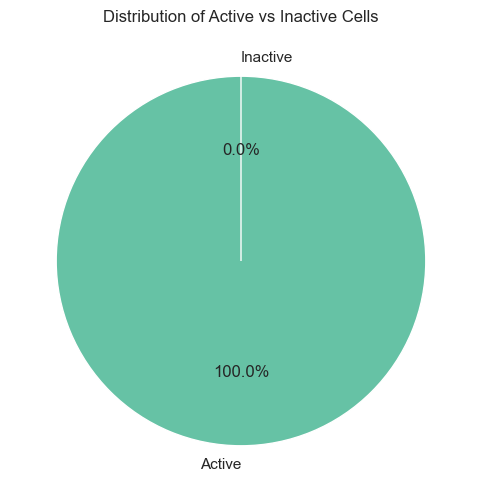

In [21]:
cell_status_counts = cells['is_active'].value_counts().reindex([1, 0]).fillna(0)
cell_status_counts.index = ['Active', 'Inactive']
total_cells = int(cell_status_counts.sum())
for label, count in cell_status_counts.items():
    percent = 100 * count / total_cells
    print(f"{label:<10}: {int(count)} cells ({percent:.1f}%)")

plt.figure(figsize=(6, 6))
plt.pie(cell_status_counts, labels=cell_status_counts.index,
        autopct='%1.1f%%', startangle=90, colors=["#66c2a5", "#d3d3d3"])
plt.title("Distribution of Active vs Inactive Cells")
plt.show()

### Cell metrics

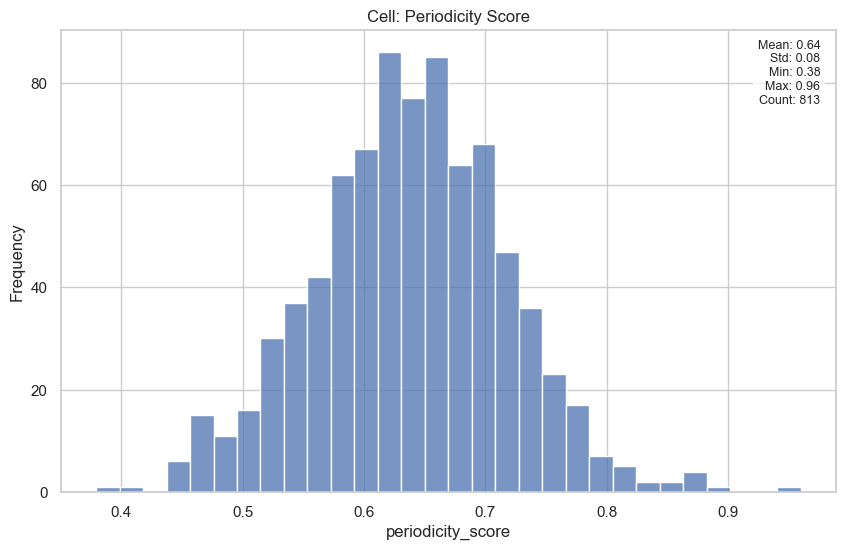

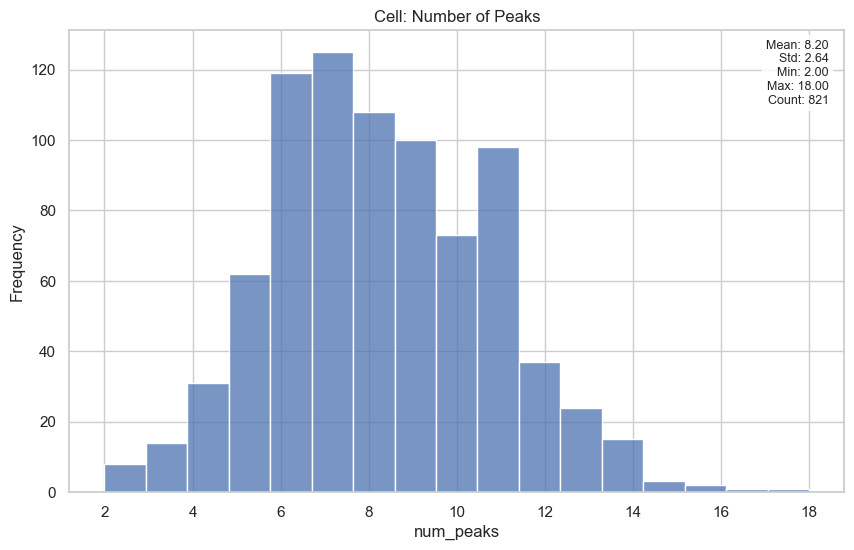

In [22]:
if "periodicity_score" not in cells.columns:
    cells["periodicity_score"] = np.nan
if "is_active" not in cells.columns:
    cells["is_active"] = cells["num_peaks"].apply(lambda x: 1 if x > 0 else 0)

plot_distribution(cells, "periodicity_score", "Cell: Periodicity Score", bin_width=0.02)
plot_distribution(cells, "num_peaks", "Cell: Number of Peaks", bin_width=1)

## 🥧 Peak Type Distribution

Global    : 1570 peaks (23.3%)
Sequential: 2849 peaks (42.3%)
Individual: 2312 peaks (34.3%)


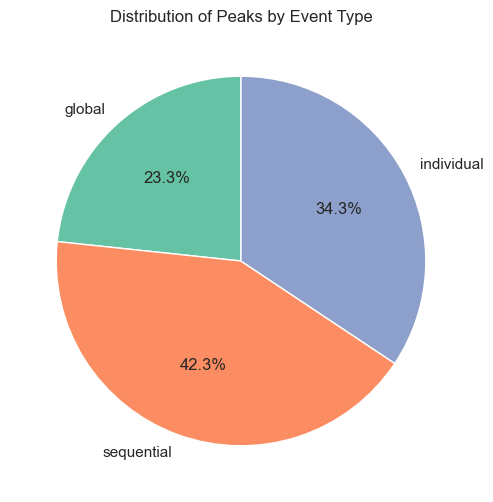

In [23]:
peak_type_counts = peaks['in_event'].value_counts().reindex(['global', 'sequential', 'individual'])
total_peaks = len(peaks)
for label, count in peak_type_counts.items():
    percent = 100 * count / total_peaks
    print(f"{label.capitalize():<10}: {count} peaks ({percent:.1f}%)")

plt.figure(figsize=(6, 6))
plt.pie(peak_type_counts, labels=peak_type_counts.index, autopct='%1.1f%%', startangle=90,
        colors=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.title("Distribution of Peaks by Event Type")
plt.show()

## Peak analysis per event type

### 🌍 Global Peaks


🔹 Summary for Global peaks:
  Count: 1570
  Mean Duration: 96.71 ± 52.31
  Mean Prominence: 239.52 ± 190.29
  Mean Height: 587.03 ± 220.13
  Mean Symmetry: 0.69 ± 0.22
  Cells Involved: 819


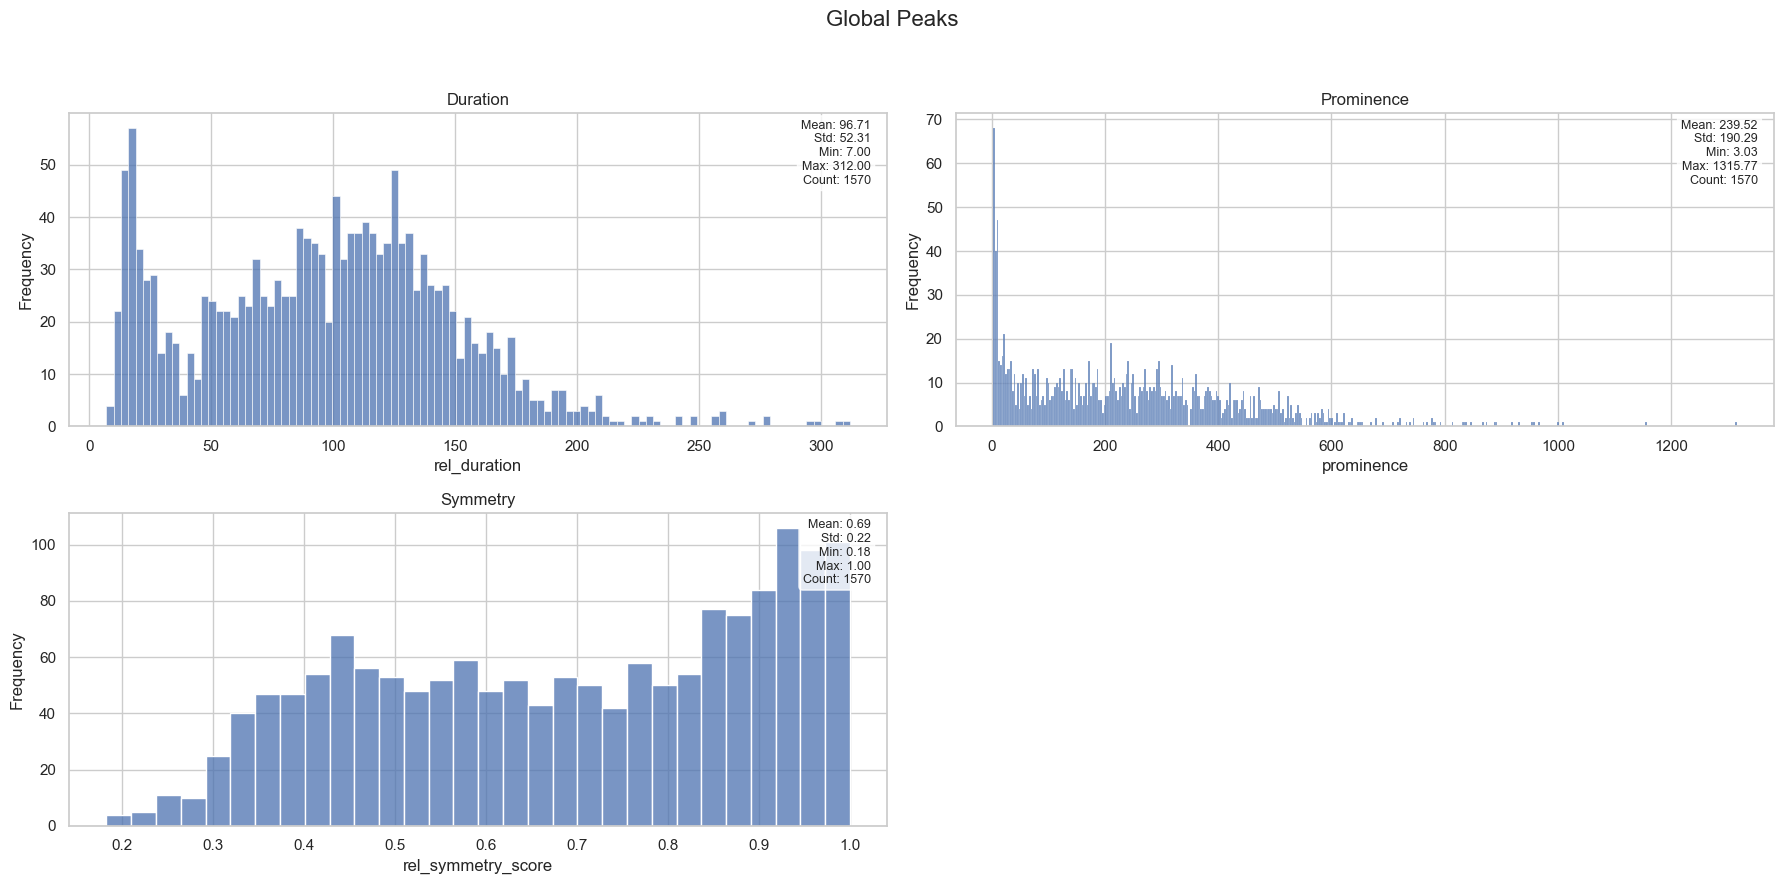

In [24]:
summarize_peak_set(global_peaks, "Global")
plot_subplots(global_peaks, "Global Peaks",
              columns=("rel_duration", "prominence", "rel_symmetry_score"),
              titles=("Duration", "Prominence", "Symmetry"),
              bin_widths=(3, 3, None), bins=(None, None, 30))

### 🔁 Sequential Peaks


🔹 Summary for Sequential peaks:
  Count: 2849
  Mean Duration: 31.30 ± 21.53
  Mean Prominence: 34.63 ± 69.98
  Mean Height: 366.82 ± 181.37
  Mean Symmetry: 0.89 ± 0.13
  Cells Involved: 776


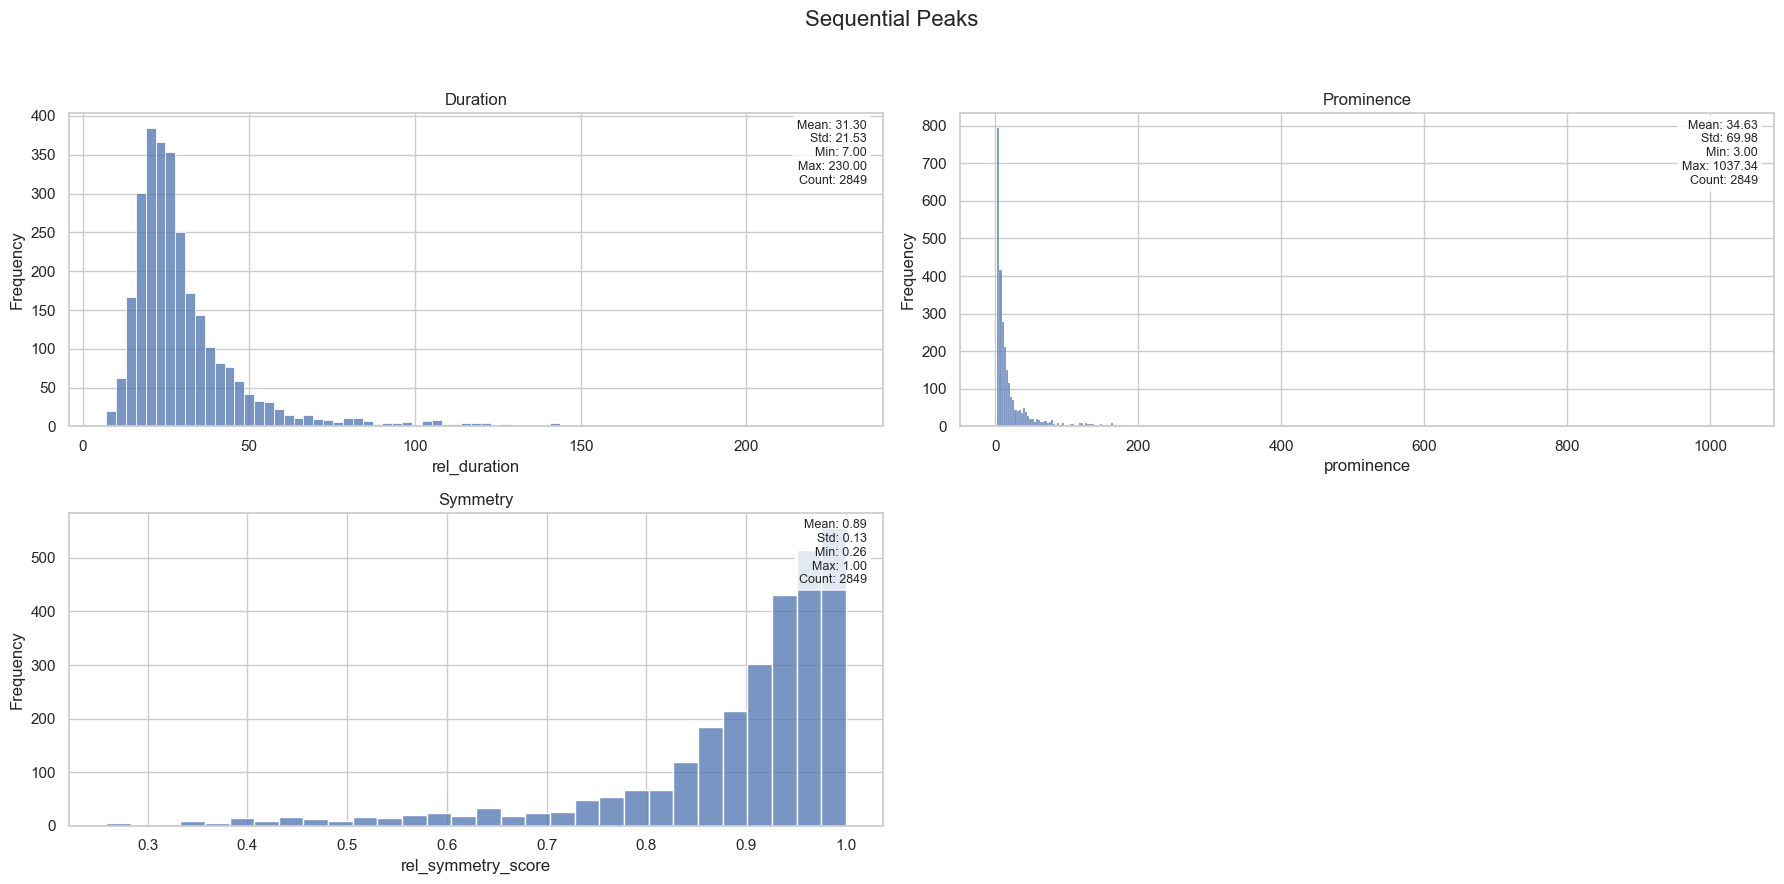

In [25]:
summarize_peak_set(sequential_peaks, "Sequential")
plot_subplots(sequential_peaks, "Sequential Peaks",
              columns=("rel_duration", "prominence", "rel_symmetry_score"),
              titles=("Duration", "Prominence", "Symmetry"),
              bin_widths=(3, 3, None), bins=(None, None, 30))

### ⚪ Individual Peaks


🔹 Summary for Individual peaks:
  Count: 2312
  Mean Duration: 30.39 ± 22.08
  Mean Prominence: 30.28 ± 71.05
  Mean Height: 346.26 ± 157.14
  Mean Symmetry: 0.89 ± 0.13
  Cells Involved: 708


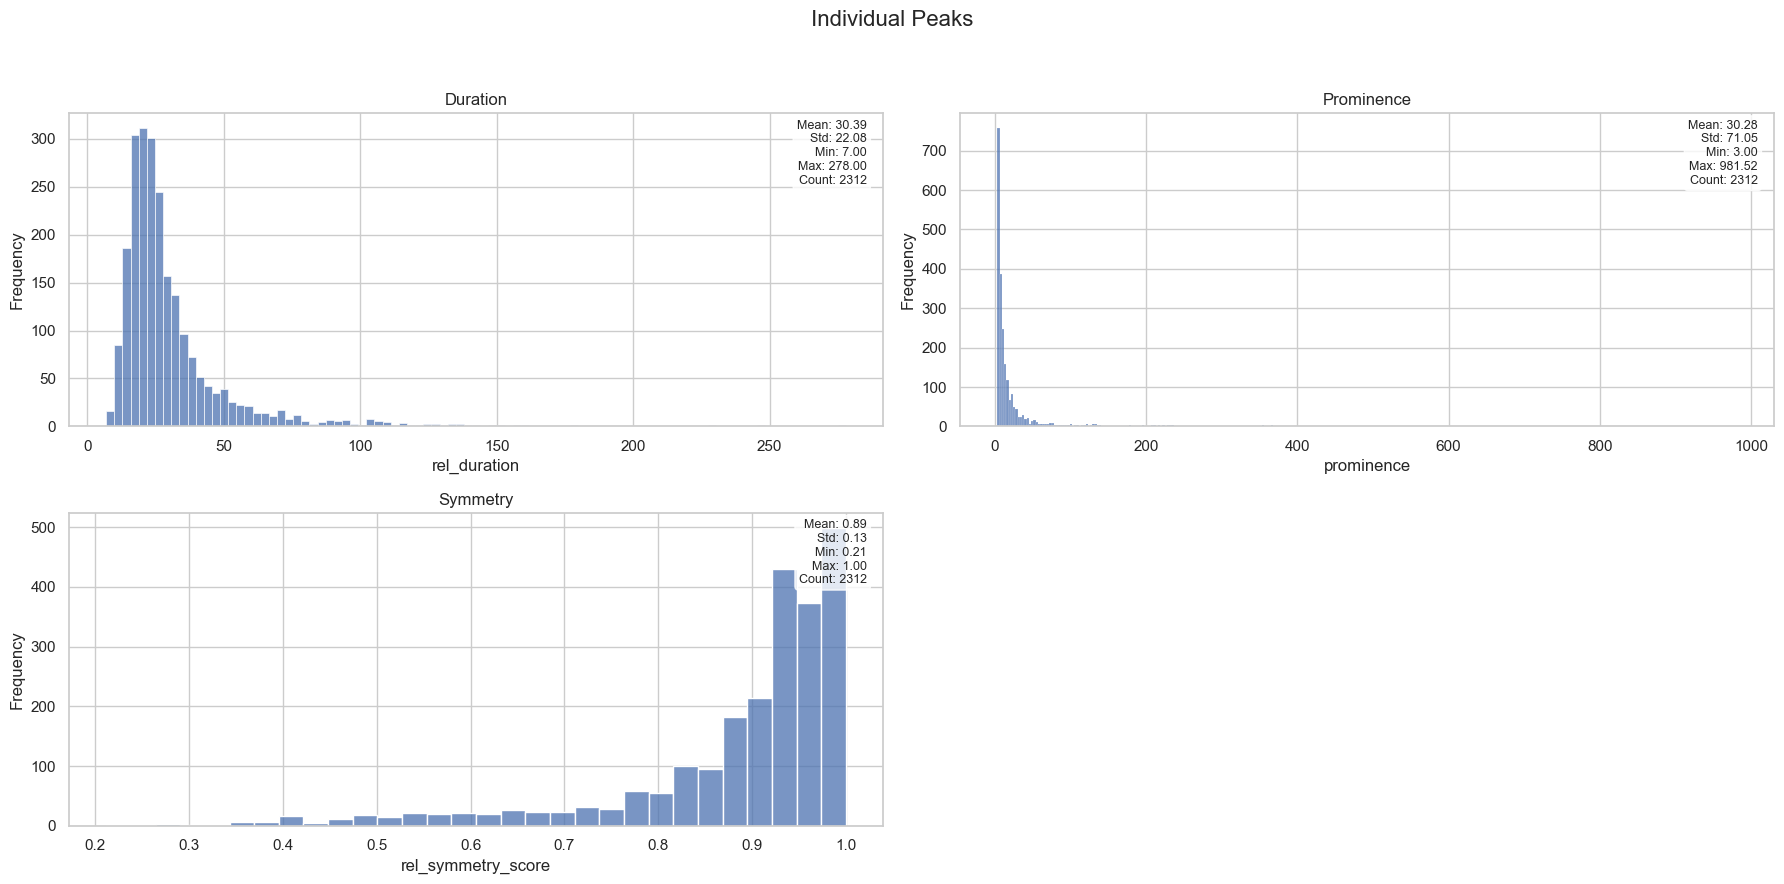

In [26]:
summarize_peak_set(individual_peaks, "Individual")
plot_subplots(individual_peaks, "Individual Peaks",
              columns=("rel_duration", "prominence", "rel_symmetry_score"),
              titles=("Duration", "Prominence", "Symmetry"),
              bin_widths=(3, 3, None), bins=(None, None, 30))

## 📈 Event-Level Metrics Summary

⚠️ Skipping plot for 'dag_depth' — no valid data.


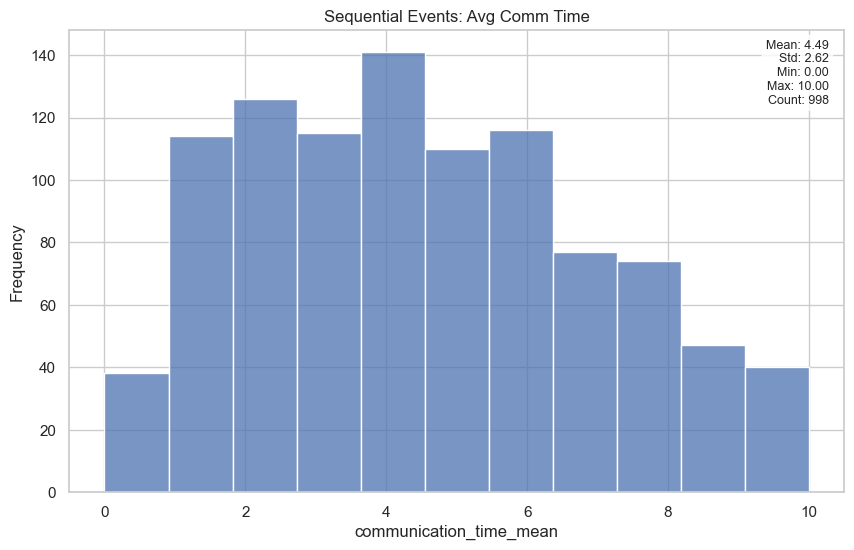

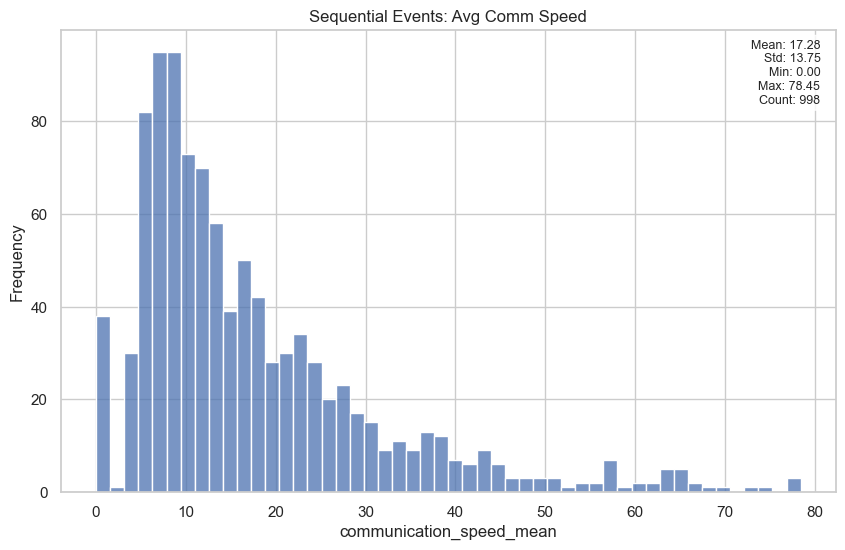

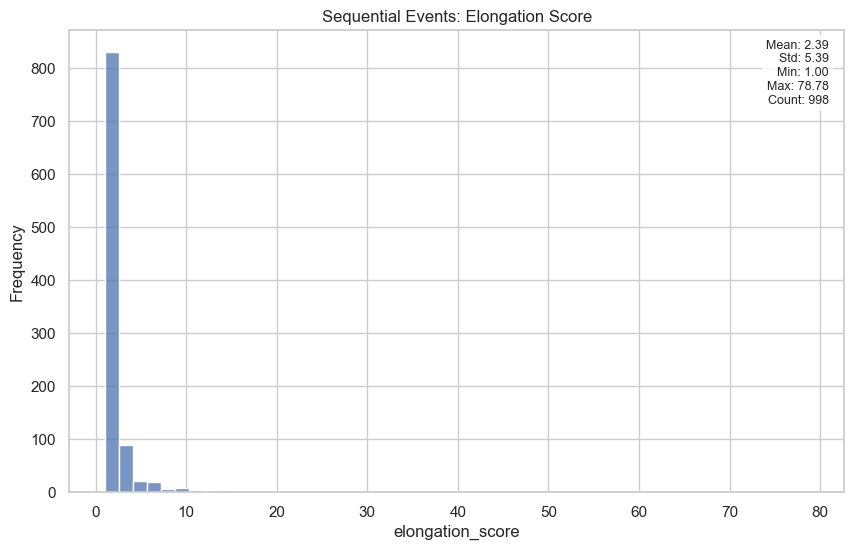

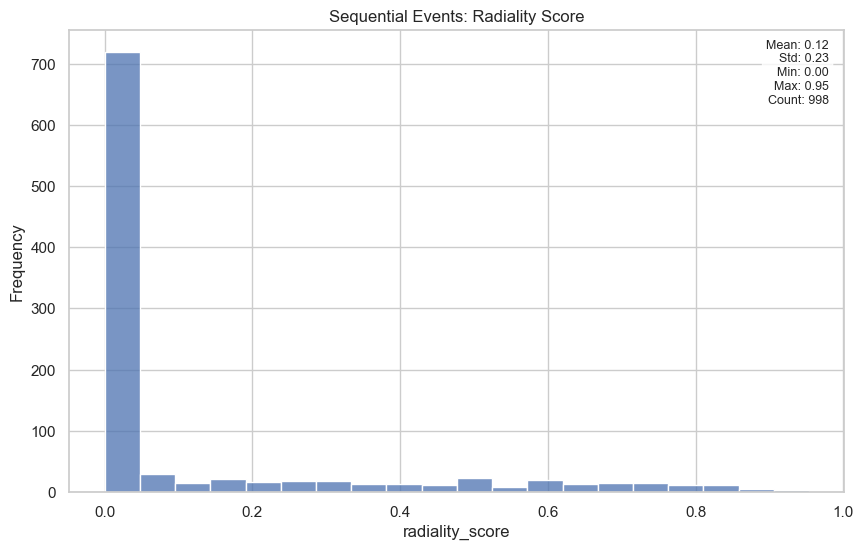

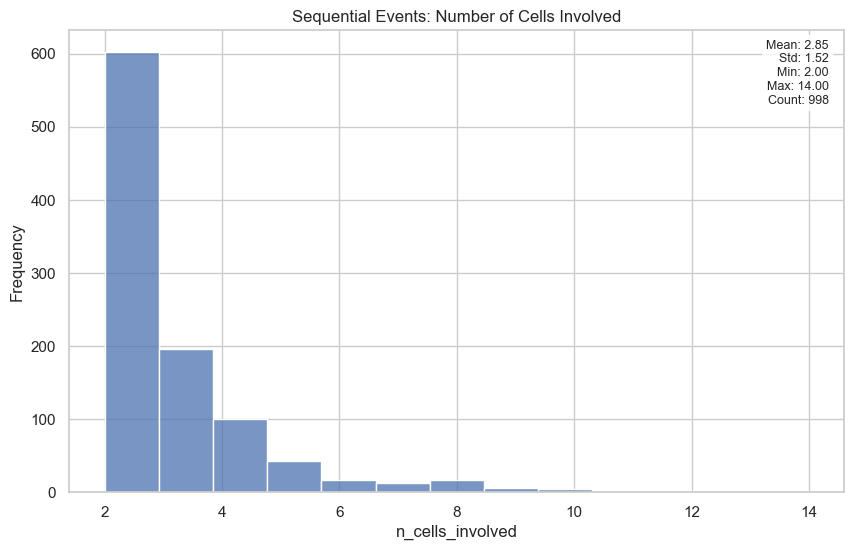

In [30]:
# 📘 Sequential Event Metrics
sequential_events = events[events["event_type"] == "SequentialEvent"]

# Communication Metrics (corrected)
plot_distribution(sequential_events, "communication_time_mean", "Sequential Events: Avg Comm Time", bin_width=1)
plot_distribution(sequential_events, "communication_speed_mean", "Sequential Events: Avg Comm Speed", bin_count=50)

# Shape Metrics
plot_distribution(sequential_events, "elongation_score", "Sequential Events: Elongation Score", bin_count=50)
plot_distribution(sequential_events, "radiality_score", "Sequential Events: Radiality Score", bin_width=0.05)

# DAG Metrics
plot_distribution(sequential_events, "dag_depth", "Sequential Events: DAG Depth", bin_width=1)

# Cell Involvement
plot_distribution(sequential_events, "n_cells_involved", "Sequential Events: Number of Cells Involved", bin_width=1)
